In [ ]:
# tensorflow
from keras.models import Sequential, Model, load_model
from keras.layers import UpSampling2D, Conv2D, Activation, BatchNormalization, \
                        Reshape, Dense, Input, LeakyReLU, ReLU, Dropout, Flatten, ZeroPadding2D, \
                        Conv2DTranspose
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import image_dataset_from_directory
import tensorflow_datasets as tfds
import tensorflow as tf

# others
import numpy as np
import os
from imageio import imwrite
from matplotlib import pyplot as plt
import matplotlib.animation as animation
import cv2 as cv
import pandas as pd
import shutil
from IPython import display
import time
%matplotlib inline

In [ ]:
# turn on acceleration
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


2022-04-26 18:30:31.465458: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-26 18:30:31.564496: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-26 18:30:31.565515: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [ ]:
# all used filepaths
discriminator_path = "data/models/discrim.h5"
generator_path = "data/models/generat.h5"
output_path = "data/output/test"
input_path = '../input/abstract-art-gallery/Abstract_gallery'
path_history = f"{output_path}/history.csv"
path_gallery = f"{output_path}/gallery_generated_"

## Helper methods

In [ ]:
def save_history(d_loss, d_acc, g_loss):
    history = pd.DataFrame({'Discriminator loss': [d_loss],
                           'Discriminator accuracy x100': [d_acc],
                           'Generator loss': [g_loss]})
    history.to_csv(path_history, mode='a', header=not os.path.exists(save_path))

In [ ]:
def save_imgs(epoch, imgs, gallery_size):
    imgs = 0.5 * imgs + 0.5

    for i, img_array in enumerate(imgs):
        path = f"{output_path}/generated_{img_size[0]}x{img_size[1]}"
        if not os.path.exists(path):
            os.makedirs(path)
        imwrite(path + f"/{epoch}_{i}.png", img_array)
    
    nindex, height, width, intensity = imgs.shape
    nrows = nindex // gallery_size[1]
    assert nindex == nrows * gallery_size[1]
    # want result.shape = (height*nrows, width*ncols, intensity)
    gallery = (imgs.reshape(nrows, gallery_size[1], height, width, intensity)
              .swapaxes(1, 2)
              .reshape(height * nrows, width * gallery_size[1], intensity))

    path = f"{output_path}/gallery_generated_{img_size[0]}x{img_size[1]}"
    if not os.path.exists(path):
        os.makedirs(path)
    imwrite(path + f"/{epoch}.png", gallery)

## DCGAN Implementation

In [ ]:
def build_generator(starting_filters, img_size, upsample_layers, kernel_size, channels, noise_shape=(100,)):
    # This block of code can be a little daunting, but essentially it automatically calculates the required starting
    # array size that will be correctly upscaled to our desired image size.
    #
    # We have 5 Upsample2D layers which each double the images width and height, so we can determine the starting
    # x size by taking (x / 2^upsample_count) So for our target image size, 256x192, we do the following:
    # x = (192 / 2^5), y = (256 / 2^5) [x and y are reversed within the model]
    # We also need a 3rd dimension which is chosen relatively arbitrarily, in this case it's 64.
    model = Sequential()
    model.add(
        Dense(starting_filters * (img_size[0] // (2 ** upsample_layers))  *  (img_size[1] // (2 ** upsample_layers)),
              activation="relu", input_shape=noise_shape))
    model.add(Reshape(((img_size[0] // (2 ** upsample_layers)),
                       (img_size[1] // (2 ** upsample_layers)),
                       starting_filters)))
    model.add(BatchNormalization(momentum=0.8))

    model.add(UpSampling2D())  # 6x8 -> 12x16
    model.add(Conv2D(1024, kernel_size=kernel_size, padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(momentum=0.8))

    model.add(UpSampling2D())  # 12x16 -> 24x32
    model.add(Conv2D(512, kernel_size=kernel_size, padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(momentum=0.8))

    model.add(UpSampling2D())  # 24x32 -> 48x64
    model.add(Conv2D(256, kernel_size=kernel_size, padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(momentum=0.8))

    model.add(UpSampling2D())  # 48x64 -> 96x128
    model.add(Conv2D(128, kernel_size=kernel_size, padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(momentum=0.8))

    model.add(UpSampling2D())  # 96x128 -> 192x256
    model.add(Conv2D(64, kernel_size=kernel_size, padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(momentum=0.8))

    model.add(Conv2D(32, kernel_size=kernel_size, padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(momentum=0.8))

    model.add(Conv2D(channels, kernel_size=kernel_size, padding="same"))
    model.add(Activation("tanh"))

    model.summary()

    noise = Input(shape=noise_shape)
    img = model(noise)

    return Model(inputs=noise, outputs=img, name='Generator')

In [ ]:
def build_generator_2(kernel_size, noise_shape=(100,)):
    model = Sequential(name='Generator')
    
    model.add(Dense(4*4*64, input_shape=noise_shape))
    model.add(Reshape((4, 4, 64)))
    
    model.add(BatchNormalization())
    model.add(UpSampling2D())
    model.add(Conv2D(1024, kernel_size, strides=(1,1), padding='same'))
    
    model.add(ReLU())
    model.add(BatchNormalization())
    model.add(UpSampling2D())
    model.add(Conv2D(512, kernel_size, strides=(1,1), padding='same'))
    
    model.add(ReLU())
    model.add(BatchNormalization())
    model.add(UpSampling2D())
    model.add(Conv2D(256, kernel_size, strides=(1,1), padding='same'))
    
    model.add(ReLU())
    model.add(BatchNormalization())
    model.add(UpSampling2D())
    model.add(Conv2D(128, kernel_size, strides=(1,1), padding='same'))
    
    model.add(ReLU())
    model.add(BatchNormalization())
    model.add(UpSampling2D())
    model.add(Conv2D(64, kernel_size, strides=(1,1), padding='same'))
    
    model.add(ReLU())
    model.add(BatchNormalization())
    model.add(Conv2D(32, kernel_size, strides=(1,1), padding='same'))
    
    model.add(ReLU())
    model.add(BatchNormalization())
    model.add(Conv2D(3, kernel_size, strides=(1,1), padding='same'))
    model.add(Activation("tanh"))
    
    model.build(noise_shape)
    
    model.summary()

    noise = Input(shape=noise_shape)
    img = model(noise)

    return Model(inputs=noise, outputs=img, name='Generator')

In [ ]:
def build_discriminator(img_size, channels, kernel_size, ):
    img_shape = (img_size[0], img_size[1], channels)

    model = Sequential()

    model.add(Conv2D(32, kernel_size=kernel_size, strides=2, input_shape=img_shape, padding="same"))  # 192x256 -> 96x128
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, kernel_size=kernel_size, strides=2, padding="same"))  # 96x128 -> 48x64
    model.add(ZeroPadding2D(padding=((0, 1), (0, 1))))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(BatchNormalization(momentum=0.8))

    model.add(Conv2D(128, kernel_size=kernel_size, strides=2, padding="same"))  # 48x64 -> 24x32
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(BatchNormalization(momentum=0.8))

    model.add(Conv2D(256, kernel_size=kernel_size, strides=1, padding="same"))  # 24x32 -> 12x16
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Conv2D(512, kernel_size=kernel_size, strides=1, padding="same"))  # 12x16 -> 6x8
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    model.summary()

    img = Input(shape=img_shape)
    validity = model(img)

    return Model(inputs=img, outputs=validity, )


## Loading dataset

In [ ]:
img_size = (128, 128)

In [ ]:
def load_imgs(image_path, img_size):
    dataset = image_dataset_from_directory(image_path, image_size=img_size)
    example_batch = dataset.take(1)
    for images, labels in example_batch:
        for i in range(32):
            ax = plt.subplot(4, 8, i + 1)
            ax.set_xticks([])
            ax.set_yticks([])
            plt.imshow(images[i].numpy().astype("uint8"))
    return dataset

In [ ]:
def preprocess_imgs(dataset):
    normalization = tf.keras.layers.Rescaling(scale=1./127.5, offset=-1)
    dataset = dataset.map(lambda x, y: (normalization(x), y))
    dataset = tfds.as_numpy(dataset)
    X_train = []
    for batch in dataset:
        X_train.append(batch[0])
    X_train = np.concatenate(X_train, axis=0)
    return np.asarray(X_train)

Found 2782 files belonging to 1 classes.


2022-04-26 18:30:38.539189: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-26 18:30:38.540392: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-26 18:30:38.541502: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-26 18:30:38.542513: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

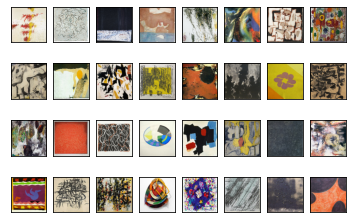

In [ ]:
dataset = load_imgs(input_path, img_size)

In [ ]:
X_train = preprocess_imgs(dataset)
print("Training Data Shape: ", X_train.shape)
X_train[1]

## Building model

In [ ]:
kernel_size = 4
channels = 3
# upsample_layers = 5
# starting_filters = 64

In [ ]:
# optimizer = Adam(0.0001, 0.5)
optimizer = Adam(0.0001)
# See if the specified model paths exist, if they don't then we start training new models

if os.path.exists(discriminator_path) and os.path.exists(generator_path):
    discriminator = load_model(discriminator_path)
    generator = load_model(generator_path)
    print("Loaded models...")
else:
    print("No saved models were found")
#     generator = build_generator(starting_filters, img_size, upsample_layers, kernel_size, channels)
    generator = build_generator_2(kernel_size)
    generator.compile(loss='binary_crossentropy', optimizer=optimizer)
    discriminator = build_discriminator(img_size, channels, kernel_size)
    discriminator.compile(loss='binary_crossentropy',
                               optimizer=optimizer,
                               metrics=['accuracy'])

# These next few lines setup the training for the GAN model
z = Input(shape=(100,))
img = generator(z)

discriminator.trainable = False

valid = discriminator(img)

dcgan = Model(z, valid)
dcgan.compile(loss='binary_crossentropy', optimizer=optimizer)

No saved models were found
Model: "Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              103424    
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 64)          0         
_________________________________________________________________
batch_normalization (BatchNo (None, 4, 4, 64)          256       
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d (Conv2D)              (None, 8, 8, 1024)        1049600   
_________________________________________________________________
re_lu (ReLU)                 (None, 8, 8, 1024)        0         
_________________________________________________________________
batch_normalization_1 (Batch (

## Training

In [ ]:
epochs = 500
batch_size = 64
save_interval = 25

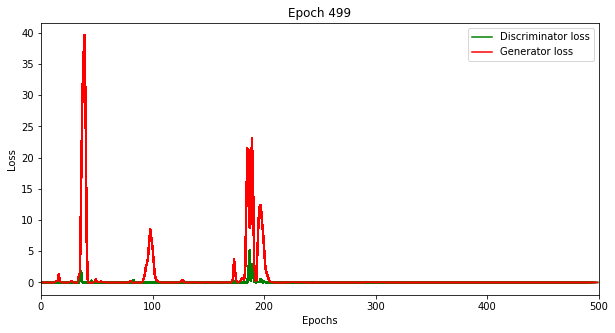

In [ ]:
half_batch = batch_size // 2

d_losses = []
g_losses = []
epochs_range = []
figure, ax = plt.subplots(figsize=(10,5))
d_line = ax.plot(epochs_range, d_losses, 'g-', label='Discriminator loss')
g_line = ax.plot(epochs_range, g_losses, 'r-', label='Generator loss')
ax.set_xlim(0,epochs)
ax.legend()

plt.xlabel("Epochs")
plt.ylabel("Loss")

for epoch in range(epochs):


    # Train Generator
    noise = np.random.normal(0, 1, (batch_size, 100))
    g_loss = dcgan.train_on_batch(noise, np.ones((batch_size, 1)))

    # Train Discriminator
    idx = np.random.randint(0, X_train.shape[0], half_batch)
    imgs = X_train[idx]

    # Sample noise and generate a half batch of new images
    noise = np.random.normal(0, 1, (half_batch, 100))
    gen_imgs = generator.predict(noise)

    # Train the discriminator (real classified as ones and generated as zeros)
    d_loss_real = discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
    d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    d_losses.append(d_loss[0])
    g_losses.append(g_loss)
    epochs_range.append(epoch)
    print("Plotting...")
    d_line = ax.plot(epochs_range, d_losses, 'g-', label='Discriminator loss')
    g_line = ax.plot(epochs_range, g_losses, 'r-', label='Generator loss')
    ax.set_title(f"Epoch {epoch}")

    display.display(plt.gcf())
    display.clear_output(wait=True)
#     time.sleep(1)
    
    # Print progress
    # print(f"{epoch} [D loss: {d_loss[0]} | D Accuracy: {100 * d_loss[1]}] [G loss: {g_loss}]")

    # If at save interval => save generated image samples, save model files
    if epoch % (save_interval) == 0:
        gallery_size = (5, 5)
        noise = np.random.normal(0, 1, (gallery_size[0]*gallery_size[1], 100))
        imgs_to_save = generator.predict(noise)
        
        save_imgs(epoch, imgs_to_save, gallery_size)

        save_path = output_path + "/models"
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        discriminator.save(save_path + "/discrim.h5")
        generator.save(save_path + "/generat.h5")

    # Save history anyway
    save_history(d_loss[0], d_loss[1], g_loss)

## View results

In [ ]:
df = pd.read_csv(path_history)
df = df.rename(columns={df.columns[1]: "Discriminator loss",
               df.columns[2]: "Discriminator accuracy x100",
               df.columns[3]: "Generator loss"})
df.drop('0', axis=1, inplace=True)
df

Discriminator loss  Discriminator accuracy x100  Generator loss
0              0.604852                     0.531250        0.586180
1              0.419016                     0.906250        0.672560
2              0.592320                     0.625000        0.812128
3              0.794430                     0.453125        0.912093
4              0.813540                     0.359375        0.789953
..                  ...                          ...             ...
994            0.000013                     1.000000        0.001057
995            0.000584                     1.000000        0.000753
996            0.000170                     1.000000        0.000166
997            0.000249                     1.000000        0.000507
998            0.000071                     1.000000        0.000442

[999 rows x 3 columns]

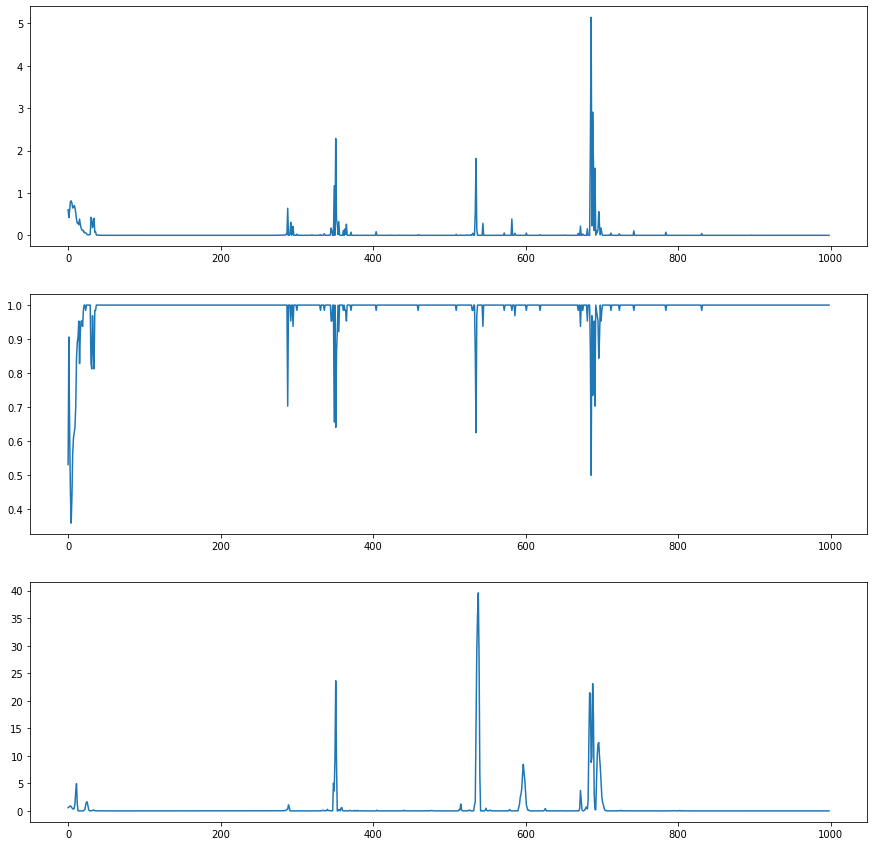

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(15,15))
ax1.plot(df["Discriminator loss"])
ax2.plot(df["Discriminator accuracy x100"])
ax3.plot(df["Generator loss"])

In [ ]:
from functools import cmp_to_key
def sorter(x1, x2):
    n1 = int(x1[:-4])
    n2 = int(x2[:-4])
    return n1 - n2

In [ ]:
! ls -lha data/output/test/gallery_generated_128x128

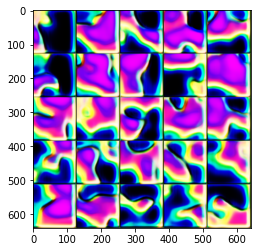

In [ ]:
temp_img = cv.imread('data/output/test/gallery_generated_128x128/650.png')
plt.imshow(temp_img)

In [ ]:
path_gallery_size = path_gallery + f"{img_size[0]}x{img_size[1]}"

In [ ]:
img_names = os.listdir(path_gallery_size)
img_names.sort(key=cmp_to_key(sorter))
len(img_names)

40

In [ ]:
img_names

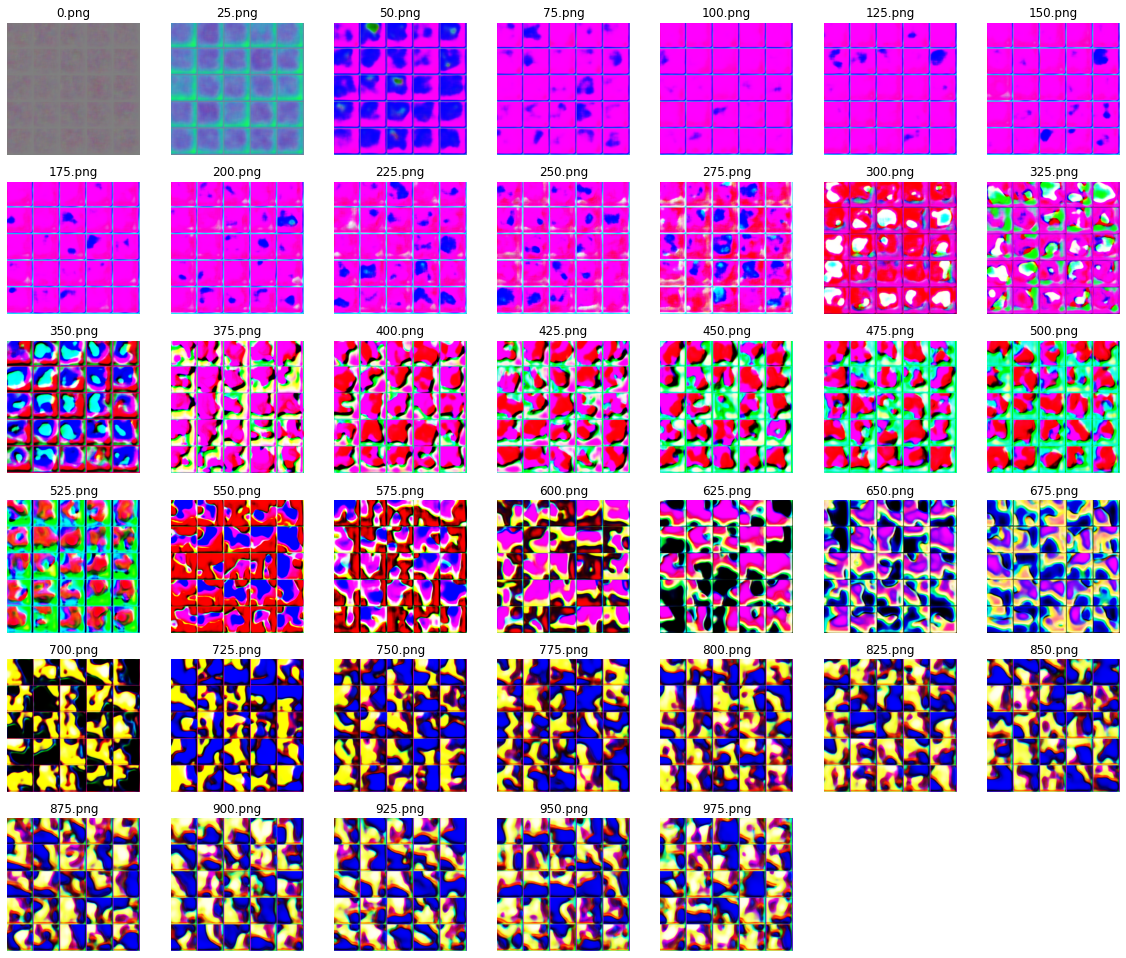

In [ ]:
img_list = []
plt.figure(figsize=(20,20))
for i in range(len(img_names)):
    ax = plt.subplot(7,7,i+1)
    img_path = path_gallery_size+'/'+img_names[i]
    img = cv.imread(img_path)
    img_list.append(img)
    scale_percent = 200 # percent of original size
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)    
    cv.resize(img, dim)
    plt.imshow(img)
    plt.axis("off")
    ax.set_title(img_names[i])

In [ ]:
noise = np.random.normal(0, 1, (1, 100))
generated = generator.predict(noise)
generated

In [ ]:
generated = generated * 0.5 + 0.5

In [ ]:
generated

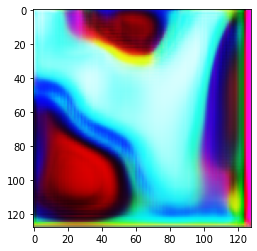

In [ ]:
plt.imshow(generated[0])

In [ ]:
test_dataset = load_imgs(input_path, img_size)

In [ ]:
batch = test_dataset.take(1)
for images, labels in batch:
    for i in range(32):
        # print(images[i].numpy().astype("uint8"))

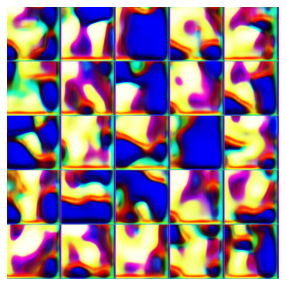

In [ ]:
fig = plt.figure(figsize=(5,5))
plt.axis("off")
ims = [[plt.imshow(img, animated=True)] for img in img_list]
gif = animation.ArtistAnimation(fig, ims, interval=250, repeat_delay=250, blit=True)

display.HTML(gif.to_jshtml())

## Clean up

In [ ]:
shutil.rmtree("data/output/test")

In [ ]:
os.path.exists("data/output/test")

False